In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import tensorflow.keras.layers as tfl

from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation
import random
#tf.compat.v1.enable_eager_execution(
 #   config=None, device_policy=None, execution_mode=None
#)

In [92]:
# seed must be equal for both training and validation not to overlap.
BATCH_SIZE = 32
IMG_SIZE = (150, 150)  # resolution
directory = "Dataset/5000Images/"

train_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             label_mode='categorical',
                                             labels='inferred',
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='training',
                                             color_mode='rgb',
                                             seed=42)
validation_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             labels='inferred',
                                             label_mode='categorical',
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='validation',
                                             color_mode='rgb',
                                             seed=42)

Found 5000 files belonging to 8 classes.
Using 4000 files for training.
Found 5000 files belonging to 8 classes.
Using 1000 files for validation.


In [93]:
class_names = train_dataset.class_names
class_names

['Adipose Tissue',
 'Complex Stroma',
 'Debris and Mucus',
 'Empty',
 'Immune Cell Conglomerates',
 'Mucosal Glands',
 'Simple Stroma',
 'Tumour Epithelium']

In [94]:
def data_augmenter():
    '''
    Create a Sequential model composed of 2 layers
    Returns:
        tf.keras.Sequential
    '''
    data_augmentation = tf.keras.Sequential()
    data_augmentation.add(RandomFlip("horizontal"))
    data_augmentation.add(RandomRotation(0.2))
    
    return data_augmentation

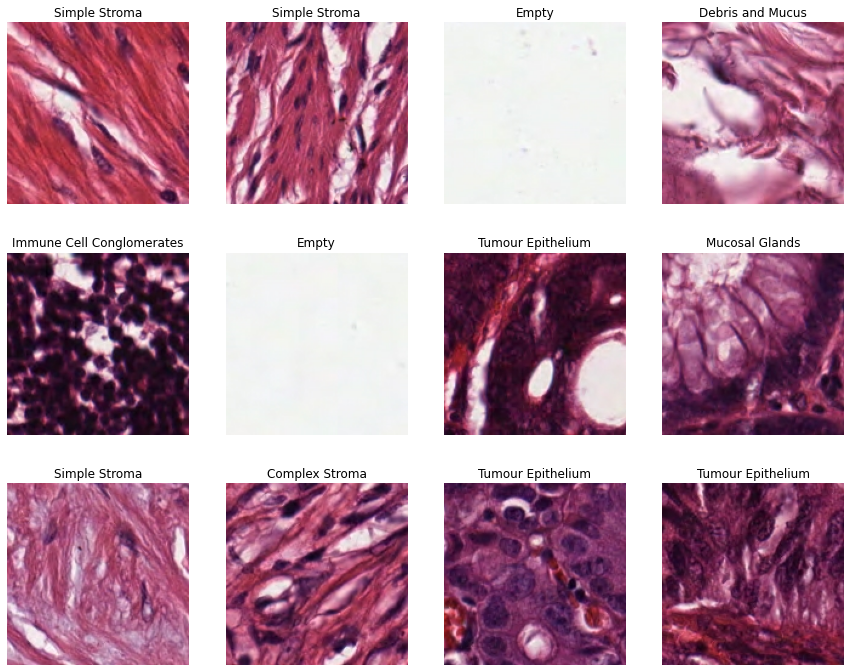

In [91]:
plt.figure(figsize=(15, 12))
for images, labels in train_dataset.take(1):
    for i in range(12):
        lbl = labels[i].numpy()
        index = np.where(lbl ==1)
        index = index[0][0]
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[index])
        plt.axis("off")

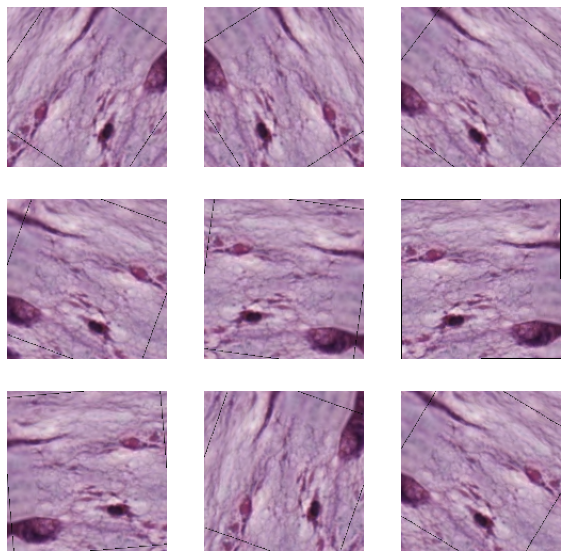

In [70]:
#preview first image augmentations
#Model Overfitted so we need some more data and ...
data_augmentation = data_augmenter()
for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0]/ 255)  # 0-1 float or 0-255 integer values
        plt.axis('off')

In [95]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
# prevents a memory bottleneck that can occur when reading from disk

In [96]:
preprocess_input = tf.keras.applications.resnet_v2.preprocess_input #data preprocessing using the same weights the model was trained on

In [97]:
# MobileNet V2 trained on imagenet data
IMG_SHAPE = IMG_SIZE + (3,) # as Img size 160*160 only but we need it 160*160*3 for the model
base_model = tf.keras.applications.ResNet101V2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [74]:
base_model.summary()

Model: "resnet101v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 156, 156, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 75, 75, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 77, 77, 64)   0           conv1_conv[0][0]                 
________________________________________________________________________________________

In [75]:
nb_layers = len(base_model.layers)
print(base_model.layers[nb_layers - 2].name)  # pre- Last name
print(base_model.layers[nb_layers - 1].name)  # Last Layer name
# Last two layers are called top layers (Classification)

post_bn
post_relu


In [98]:
# Create the breast cancer model
def BC_model(image_shape=IMG_SIZE):
    ''' Define a tf.keras model for multi-class classification out of the MobileNetV2 model
    Arguments:
        image_shape -- Image width and height
        data_augmentation -- data augmentation function
    Returns:
    Returns:
        tf.keras.model
    '''
    input_shape = image_shape + (3,)
    
    base_model = tf.keras.applications.ResNet101V2(input_shape=input_shape,
                                                   include_top=False, # <== Important!!!!
                                                   weights='imagenet') # Create the model with its weights without the top layers
     
    base_model.trainable = False  # not to train any of the base model and train only the new layers will be added
    inputs = tf.keras.Input(shape=input_shape)
    
    #x = data_augmentation(inputs) # augmenting the input
        
    x = preprocess_input(inputs) #data preprocessing using the same weights the model was trained on
    
    x = base_model(x, training=False)
    
    x = tfl.GlobalAveragePooling2D()(x)
    x = tfl.Dropout(0.3)(x)
    prediction_layer = tfl.Dense(8, activation='softmax') 
    outputs = prediction_layer(x) 
    model = tf.keras.Model(inputs, outputs)
    print(model.summary())
    return model
    

In [99]:
BCModel = BC_model(IMG_SIZE)


Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
tf_op_layer_RealDiv_2 (Tenso [(None, 150, 150, 3)]     0         
_________________________________________________________________
tf_op_layer_Sub_2 (TensorFlo [(None, 150, 150, 3)]     0         
_________________________________________________________________
resnet101v2 (Functional)     (None, 5, 5, 2048)        42626560  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 2048)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                

In [100]:
base_learning_rate = 0.01
BCModel.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [101]:
initial_epochs = 5
history = BCModel.fit(train_dataset, validation_data=validation_dataset, epochs=initial_epochs, use_multiprocessing= True)


Epoch 1/5
125/125 [==============================] - 293s 2s/step - loss: 0.8912 - accuracy: 0.7962 - val_loss: 0.7364 - val_accuracy: 0.8470
Epoch 2/5
125/125 [==============================] - 276s 2s/step - loss: 0.5634 - accuracy: 0.8655 - val_loss: 0.7420 - val_accuracy: 0.8510
Epoch 3/5
125/125 [==============================] - 272s 2s/step - loss: 0.5504 - accuracy: 0.8745 - val_loss: 0.7884 - val_accuracy: 0.8570
Epoch 4/5
125/125 [==============================] - 273s 2s/step - loss: 0.4535 - accuracy: 0.8953 - val_loss: 0.8008 - val_accuracy: 0.8690
Epoch 5/5
125/125 [==============================] - 270s 2s/step - loss: 0.3854 - accuracy: 0.9065 - val_loss: 0.9129 - val_accuracy: 0.8590


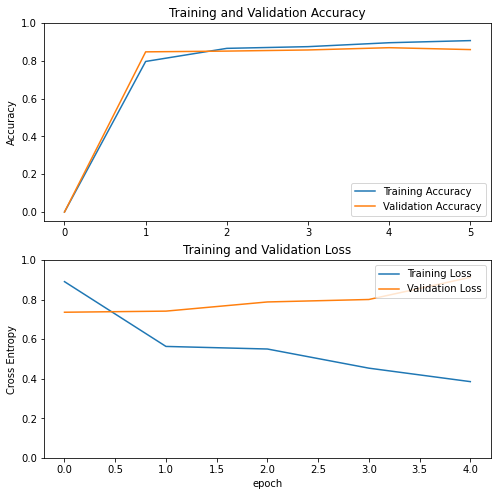

In [102]:
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [103]:
# Make it trainable from specified layer number
base_model.trainable = True # Make all trainable as a start
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  377


In [104]:
fine_tune_at = 290 # Number to choose Editted after overfitting

for layer in base_model.layers[:fine_tune_at]:
    #print('Layer ' + layer.name + ' frozen.')
    layer.trainable = False
    
# Define a BinaryCrossentropy loss function. Use from_logits=True
loss_function= 'categorical_crossentropy'
# Define an Adam optimizer with a learning rate of 0.1 * base_learning_rate
optimizer = tf.keras.optimizers.Adam(learning_rate=base_learning_rate*0.1)# 0.001
# Use accuracy as evaluation metric
metrics=['accuracy', 'TruePositives','Precision']

### END CODE HERE

BCModel.compile(loss=loss_function,
              optimizer = optimizer,
              metrics=metrics)

In [20]:
BCModel.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
tf_op_layer_RealDiv (TensorF [(None, 160, 160, 3)]     0         
_________________________________________________________________
tf_op_layer_Sub (TensorFlowO [(None, 160, 160, 3)]     0         
_________________________________________________________________
resnet101v2 (Functional)     (None, 5, 5, 2048)        42626560  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 8)                

In [105]:
fine_tune_epochs = 5
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = BCModel.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 5/10
125/125 [==============================] - 274s 2s/step - loss: 0.2762 - accuracy: 0.9298 - true_positives: 3712.0000 - precision: 0.9308 - val_loss: 0.8090 - val_accuracy: 0.8750 - val_true_positives: 875.0000 - val_precision: 0.8768
Epoch 6/10
125/125 [==============================] - 272s 2s/step - loss: 0.2216 - accuracy: 0.9385 - true_positives: 3752.0000 - precision: 0.9396 - val_loss: 0.7814 - val_accuracy: 0.8690 - val_true_positives: 867.0000 - val_precision: 0.8705
Epoch 7/10
125/125 [==============================] - 270s 2s/step - loss: 0.2089 - accuracy: 0.9470 - true_positives: 3781.0000 - precision: 0.9479 - val_loss: 0.8018 - val_accuracy: 0.8710 - val_true_positives: 867.0000 - val_precision: 0.8731
Epoch 8/10
125/125 [==============================] - 271s 2s/step - loss: 0.1832 - accuracy: 0.9500 - true_positives: 3794.0000 - precision: 0.9516 - val_loss: 0.7902 - val_accuracy: 0.8710 - val_true_positives: 867.0000 - val_precision: 0.8722
Epoch 9/10
125/1

In [106]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

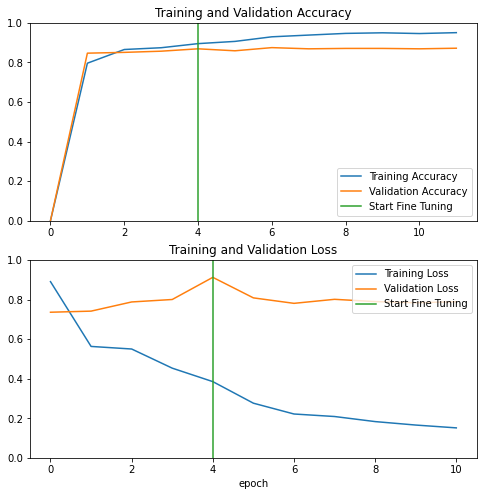

In [107]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [22]:
base_model.summary()

Model: "resnet101v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 166, 166, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 80, 80, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 82, 82, 64)   0           conv1_conv[0][0]                 
________________________________________________________________________________________

In [108]:
BCModel.evaluate(validation_dataset)

32/32 [==============================] - 55s 2s/step - loss: 0.7895 - accuracy: 0.8720 - true_positives: 871.0000 - precision: 0.8763


[0.7894901633262634, 0.871999979019165, 871.0, 0.8762575387954712]

In [109]:
BCModel.evaluate(train_dataset)

125/125 [==============================] - 231s 2s/step - loss: 0.0434 - accuracy: 0.9850 - true_positives: 3939.0000 - precision: 0.9852


[0.04342016205191612, 0.9850000143051147, 3939.0, 0.9852426052093506]

In [75]:
BCModel

{'loss': [0.6481223702430725,
  0.5908203721046448,
  0.5868381261825562,
  0.5769368410110474,
  0.5489449501037598,
  0.5700268149375916],
 'accuracy': [0.7708811163902283,
  0.7857844829559326,
  0.7807074785232544,
  0.7813625931739807,
  0.795283317565918,
  0.7802161574363708],
 'val_loss': [0.4516216814517975,
  0.41504359245300293,
  0.42265719175338745,
  0.4052271544933319,
  0.4180185794830322,
  0.39081305265426636],
 'val_accuracy': [0.8276540040969849,
  0.8387942314147949,
  0.8420707583427429,
  0.8387942314147949,
  0.8342070579528809,
  0.8420707583427429]}

Debris and Mucus


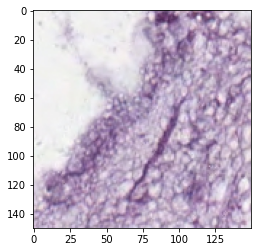

In [60]:
for imgs,labels in train_dataset.take(1):
    plt.imshow(imgs[11].numpy().astype("uint8"))
    detect = list(labels[11].numpy())
    print(class_names[detect.index(max(detect))])
    #BCModel.predict(imgs[11].numpy())

In [88]:
BCModel.save('ModelWithUpdate')

INFO:tensorflow:Assets written to: ModelWithUpdate\assets


In [2]:
#reconstructed_model = tf.keras.models.load_model("MultiClassModel")

In [5]:
#reconstructed_model.evaluate(train_dataset)

191/191 [==============================] - 72s 378ms/step - loss: 0.2614 - accuracy: 0.9145


[0.26141658425331116, 0.9145103096961975]

In [10]:
img_width, img_height = 160, 160
img = tf.keras.preprocessing.image.load_img('22580192 (26).png', target_size = (img_width, img_height))
img = tf.keras.preprocessing.image.img_to_array(img)
img = np.expand_dims(img, axis = 0)

reconstructed_model.predict(img)


array([[1.2057822e-05, 3.6341690e-02, 9.6363419e-01, 5.2765313e-06,
        3.1746109e-07, 6.3954872e-06, 2.5428882e-16, 8.0636513e-20]],
      dtype=float32)

In [12]:
converter = tf.lite.TFLiteConverter.from_saved_model("MultiClassModel")
tflite_model = converter.convert()


In [13]:
# Save the model.
with open('tflite_model.tflite', 'wb') as f:
    f.write(tflite_model)